<div style="text-align: center; font-size: 40px; font-weight: bold; color: hotpink;">
     Feature Engineering With Diabeties
</div>

It is desired to develop a machine learning model that can predict whether people have diabetes when their features are specified. 

Before developing the model, you are expected to perform the necessary data analysis and feature engineering steps.

The dataset is part of a larger dataset held by the National Institutes of Diabetes and Digestive and Kidney Diseases in the US. 

The data used for a diabetes study conducted on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city in the US state of Arizona. 

The target variable is "outcome", where 1 indicates a positive diabetes test result and 0 indicates a negative result.



Data Dictionary

| Feature                | Description                                                         |
|------------------------|---------------------------------------------------------------------|
| Pregnancies            | Number of pregnancies                                               |
| Glucose                | 2-hour plasma glucose concentration in an oral glucose tolerance test |
| Blood Pressure         | Diastolic blood pressure (mm Hg)                                    |
| SkinThickness          | Skin thickness                                                      |
| Insulin                | 2-hour serum insulin (mu U/ml)                                      |
| DiabetesPedigreeFunction | Function (2-hour plasma glucose concentration in an oral glucose tolerance test) |
| BMI                    | Body Mass Index (BMI)                                               |
| Age                    | Age (years)                                                         |
| Outcome                | Presence of disease (1) or not (0)                                  |


In [1]:
#importing the libraries and adjusting the display settings

!pip install missingno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
#reading the dataset
df = pd.read_csv("/kaggle/input/diabeties-dataset/diabetes.csv")

In [3]:
#this function provides a quik summary about the dataset
def quick_summary(dataframe, head=2):
    print("##################### HEAD #####################")
    print(dataframe .head(head))
    print("##################### TAIL #####################")
    print(dataframe.tail(head))
    print("##################### SHAPE #####################")
    print(dataframe.shape)
    print("##################### INFO #####################")
    print(dataframe.info())
    print("##################### MISSING VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### QUANTILES #####################")
    print(dataframe.describe().T)
quick_summary(df)


##################### HEAD #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
##################### TAIL #####################
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
767            1       93             70             31        0 30.400                     0.315   23        0
768            0      123             77              0        1 36.300                     0.252   55        1
##################### SHAPE #####################
(769, 9)
##################### INFO #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 9 columns):
 #   Column             

In [4]:
#converting variable names to uppercase for convineince 
df.columns = [col.upper() for col in df.columns]

In [5]:
#dentifying and categorizing the column names of the DataFrame into three types: categorical columns (cat_cols), 
#numerical columns (num_cols), #and categorical but cardinal columns (cat_but_car)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Provides the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numeric appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Threshold value for numeric but categorical variables
        car_th: int, optinal
                Threshold for categorical but not cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                categorical but cardinal list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total variable count 
        num_but_cat is included in cat_cols
        3 lists that is returned are equal to the total variable count: cat_cols + num_cols + cat_but_car = total variable count

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 769
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


         OUTCOME  Ratio
OUTCOME                
0            500 65.020
1            269 34.980
##########################################


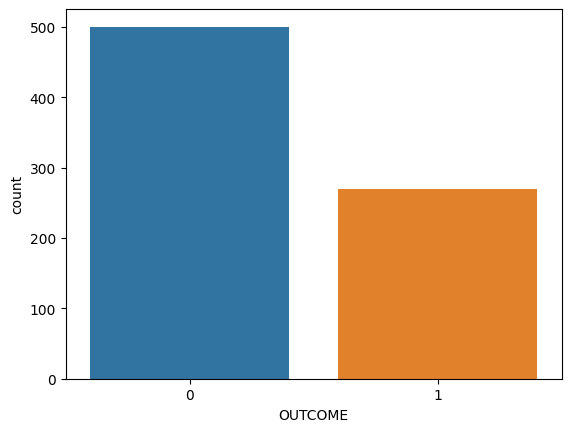

In [6]:
#summarizing and plotting categorical columns

def cat_summary(dataframe, categorical_col, plot=False):
    print(pd.DataFrame({categorical_col: dataframe[categorical_col].value_counts(),
    "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=categorical_col, data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

count   769.000
mean      3.840
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: PREGNANCIES, dtype: float64


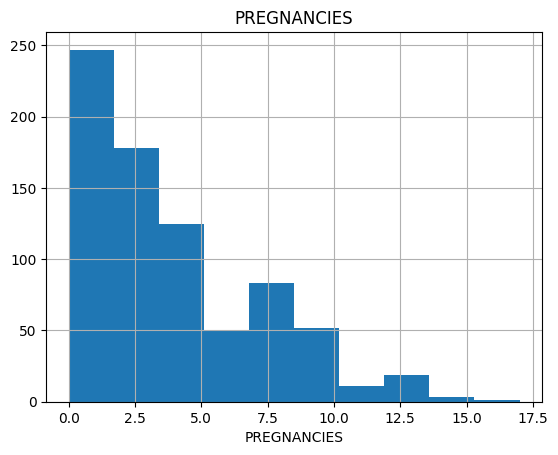

count   769.000
mean    120.897
std      31.952
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: GLUCOSE, dtype: float64


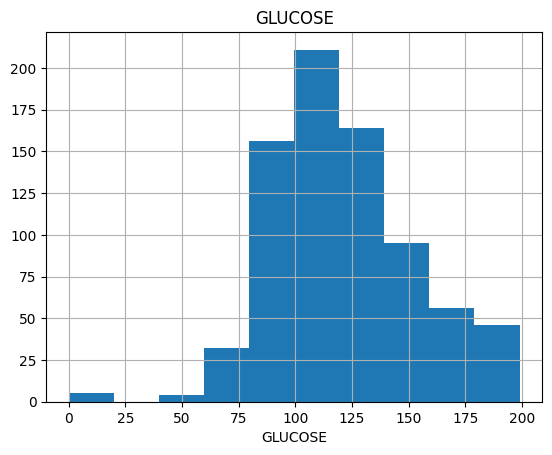

count   769.000
mean     69.116
std      19.345
min       0.000
5%       38.800
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BLOODPRESSURE, dtype: float64


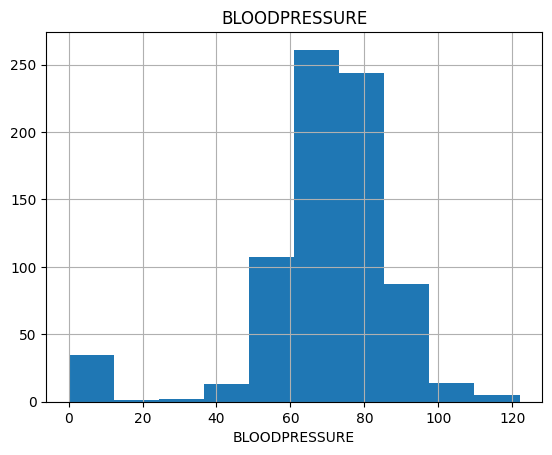

count   769.000
mean     20.510
std      15.959
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.000
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.320
max      99.000
Name: SKINTHICKNESS, dtype: float64


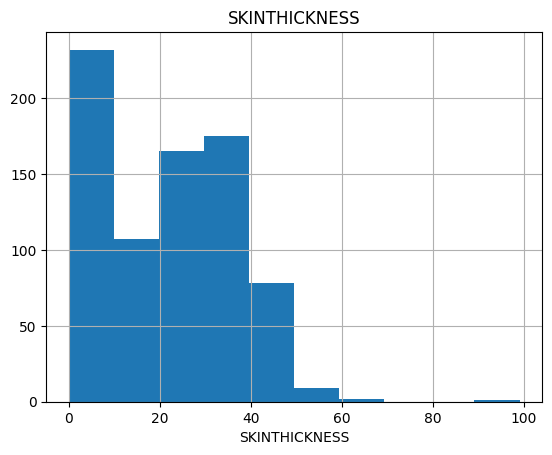

count   769.000
mean     79.697
std     115.204
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      29.000
60%      71.800
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.600
max     846.000
Name: INSULIN, dtype: float64


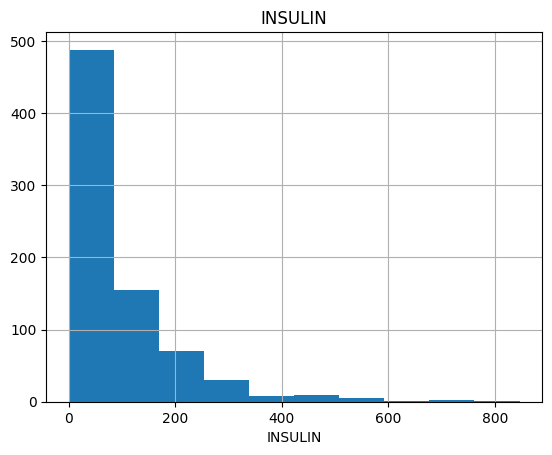

count   769.000
mean     31.998
std       7.881
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.500
80%      37.800
90%      41.500
95%      44.380
99%      50.736
max      67.100
Name: BMI, dtype: float64


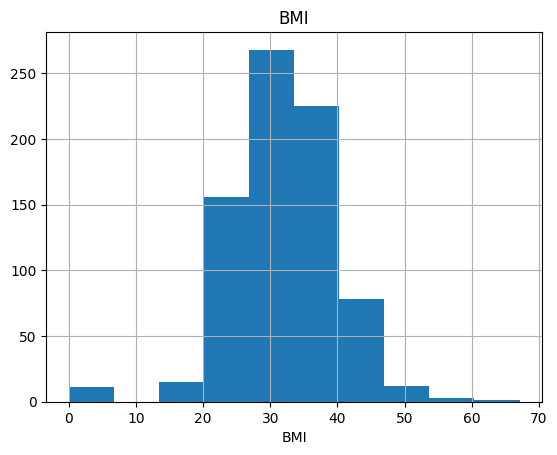

count   769.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.220
30%       0.259
40%       0.302
50%       0.371
60%       0.454
70%       0.563
80%       0.687
90%       0.878
95%       1.132
99%       1.698
max       2.420
Name: DIABETESPEDIGREEFUNCTION, dtype: float64


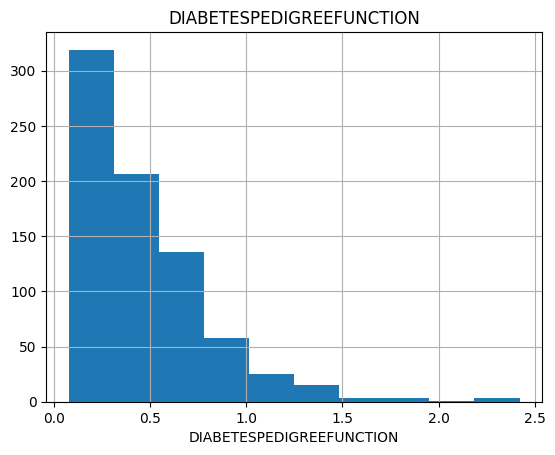

count   769.000
mean     33.269
std      11.779
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      43.000
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: AGE, dtype: float64


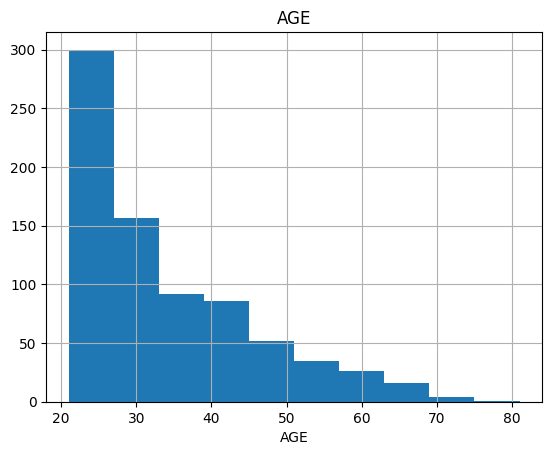

In [7]:
#summarizing and plotting numerical columns

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [8]:
#summarizing target variable with numerical columns

def target_summary_with_num(dataframe, target, numerical_col):
   print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in num_cols:
   target_summary_with_num(df, "OUTCOME", col)


         PREGNANCIES
OUTCOME             
0              3.298
1              4.848


         GLUCOSE
OUTCOME         
0        109.980
1        141.190


         BLOODPRESSURE
OUTCOME               
0               68.184
1               70.848


         SKINTHICKNESS
OUTCOME               
0               19.664
1               22.082


         INSULIN
OUTCOME         
0         68.792
1         99.967


           BMI
OUTCOME       
0       30.304
1       35.147


         DIABETESPEDIGREEFUNCTION
OUTCOME                          
0                           0.430
1                           0.549


           AGE
OUTCOME       
0       31.190
1       37.134




In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PREGNANCIES,769.000,3.840,3.370,0.000,1.000,3.000,6.000,17.000
GLUCOSE,769.000,120.897,31.952,0.000,99.000,117.000,140.000,199.000
BLOODPRESSURE,769.000,69.116,19.345,0.000,62.000,72.000,80.000,122.000
SKINTHICKNESS,769.000,20.510,15.959,0.000,0.000,23.000,32.000,99.000
INSULIN,769.000,79.697,115.204,0.000,0.000,29.000,127.000,846.000
BMI,769.000,31.998,7.881,0.000,27.300,32.000,36.600,67.100
DIABETESPEDIGREEFUNCTION,769.000,0.472,0.331,0.078,0.244,0.371,0.626,2.420
AGE,769.000,33.269,11.779,21.000,24.000,29.000,41.000,81.000
OUTCOME,769.000,0.350,0.477,0.000,0.000,0.000,1.000,1.000


In [10]:
#creating the model before conducting feature engineering to see how it works

# y = df["Outcome"]
# X = df.drop("Outcome", axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

# rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
# y_pred = rf_model.predict(X_test)


# print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
# print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
# print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
# print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
# print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")



#target variable is OUTCOME
y = df["OUTCOME"]

#dropping the target variable only
X = df.drop(["OUTCOME"], axis=1)

#dividing the dataset into two-train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

#importing RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

#establishing the model 
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

#testing the model
y_pred = rf_model.predict(X_test)

#accuraccy score of the model
accuracy_score(y_pred, y_test)

0.7445887445887446

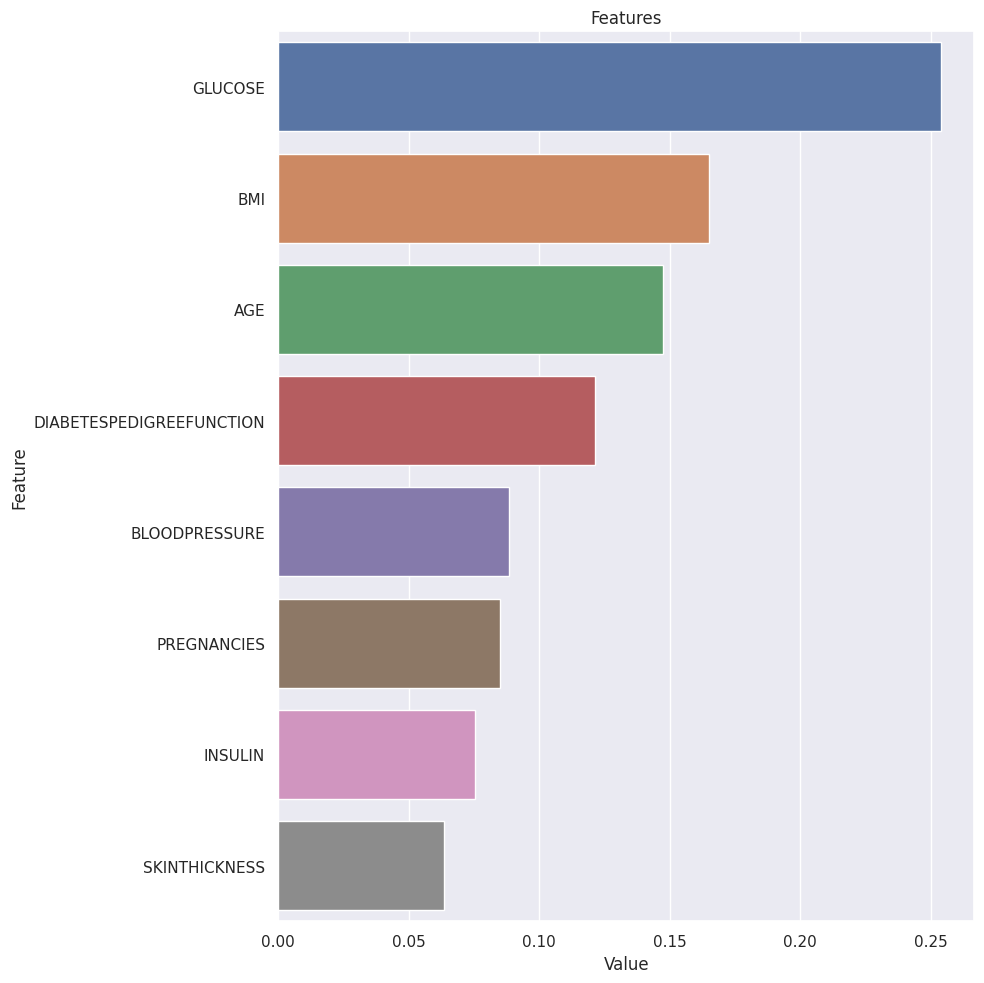

In [11]:
#plotting variables' importance in the model

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

In [12]:
#if you are gonna use tree models, you can skip handling the outliers

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [13]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [14]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [15]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [16]:
df.isnull().sum()

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [17]:
#finding out the variable that shouldn't have zeros

def check_zeros(dataframe, col_name):
    count_zeros = dataframe[dataframe[col_name] == 0].shape[0]
    print("##################### Zeros #####################")
    print(f"{col_name}:  {count_zeros}")


for col in df.columns:
    check_zeros(df, col)

##################### Zeros #####################
PREGNANCIES:  112
##################### Zeros #####################
GLUCOSE:  5
##################### Zeros #####################
BLOODPRESSURE:  35
##################### Zeros #####################
SKINTHICKNESS:  228
##################### Zeros #####################
INSULIN:  374
##################### Zeros #####################
BMI:  11
##################### Zeros #####################
DIABETESPEDIGREEFUNCTION:  0
##################### Zeros #####################
AGE:  0
##################### Zeros #####################
OUTCOME:  500


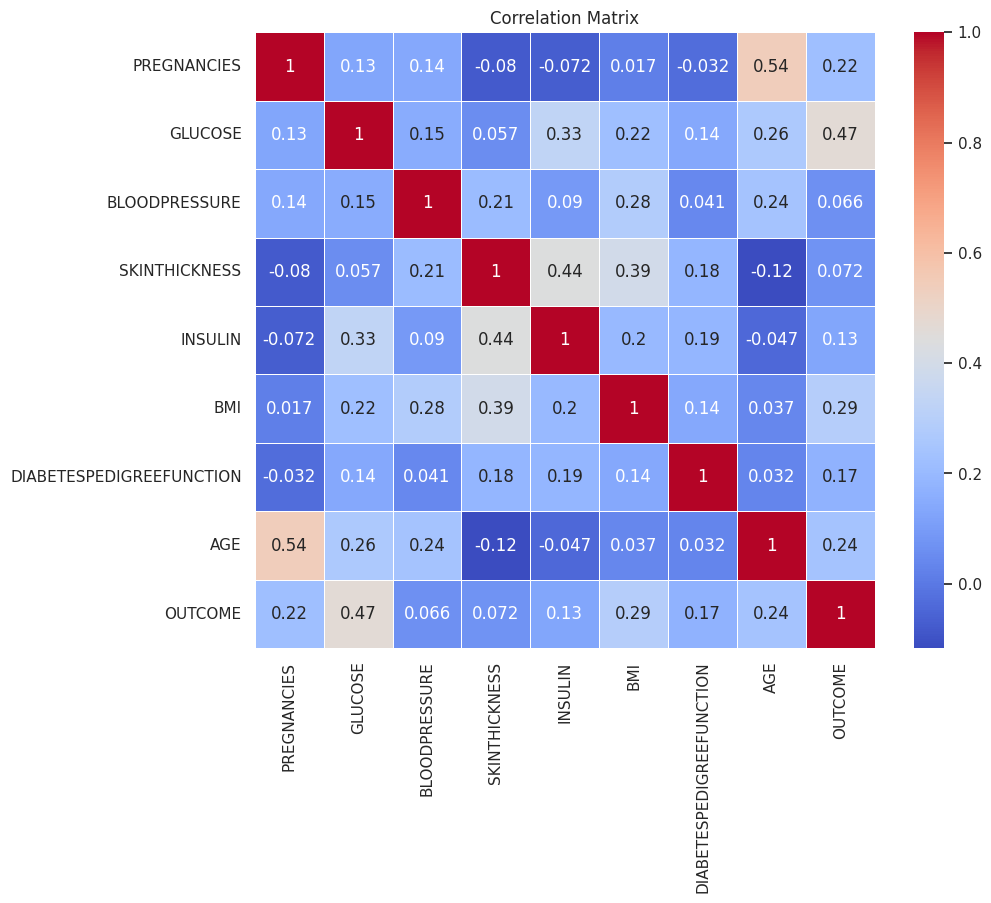

In [18]:
#creating the correlation matrix for the entire variables to see the correlation between them
#correlation Matrix
# f, ax = plt.subplots(figsize=[18, 13])
# sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
# ax.set_title("Correlation Matrix", fontsize=20)
# plt.show()

# diabetic = df[df.Outcome == 1]
# healthy = df[df.Outcome == 0]

# plt.scatter(healthy.Age, healthy.Insulin, color="green", label="Healthy", alpha = 0.4)
# plt.scatter(diabetic.Age, diabetic.Insulin, color="red", label="Diabetic", alpha = 0.4)
# plt.xlabel("Age")
# plt.ylabel("Insulin")
# plt.legend()
# plt.show()

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [19]:
#the following variables' values shouldn't be zeros, hence converting the zeros to NaNs

df[["GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI"]] = df[["GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI"]].replace(0, np.NaN)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50.000,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31.000,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32.000,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1


In [20]:
df.isnull().sum()

PREGNANCIES                   0
GLUCOSE                       5
BLOODPRESSURE                35
SKINTHICKNESS               228
INSULIN                     374
BMI                          11
DIABETESPEDIGREEFUNCTION      0
AGE                           0
OUTCOME                       0
dtype: int64

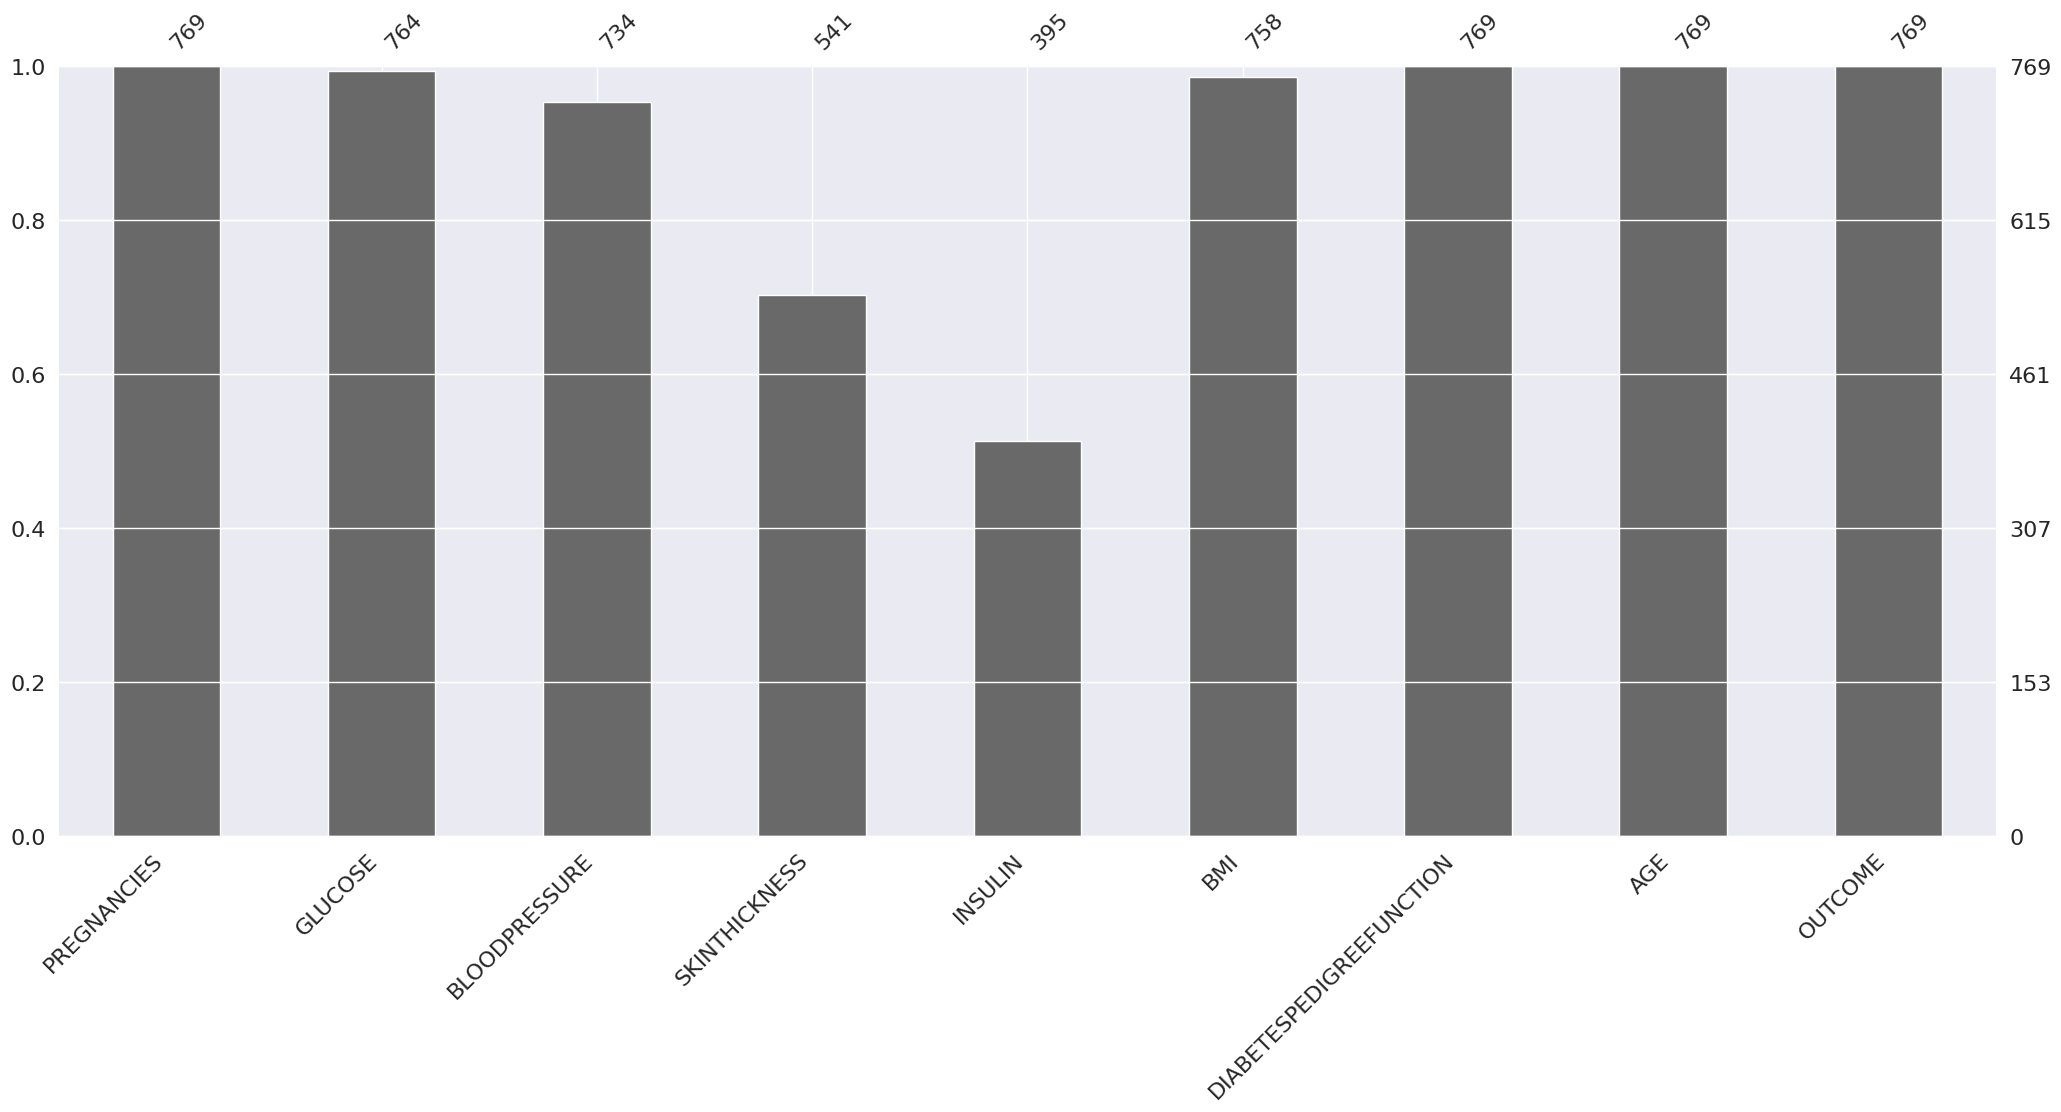

In [21]:
#displaying a bar chart showing the count of non-null values for each column 
msno.bar(df)
plt.show()

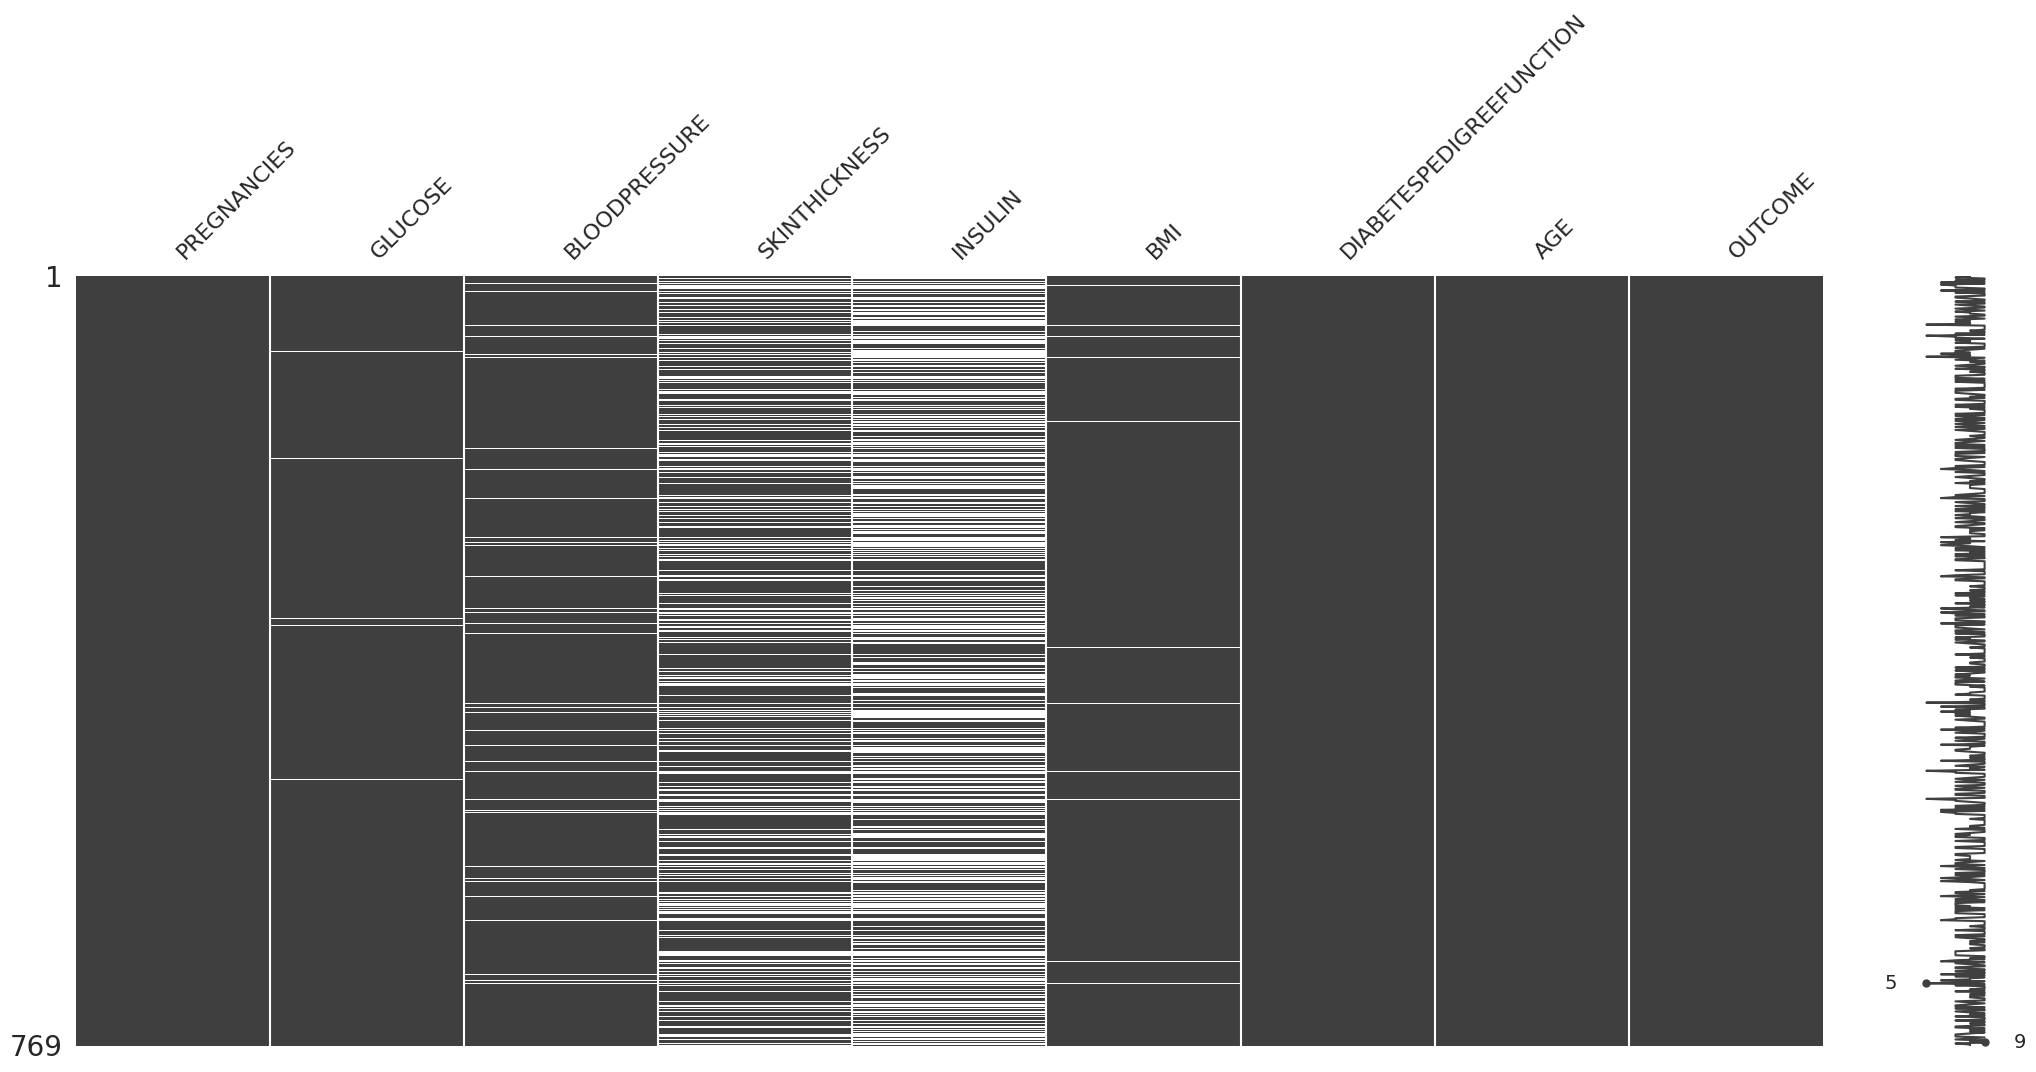

In [22]:
#displaying a matrix visualization, showing the pattern of missing data across rows and columns.
msno.matrix(df)
plt.show()

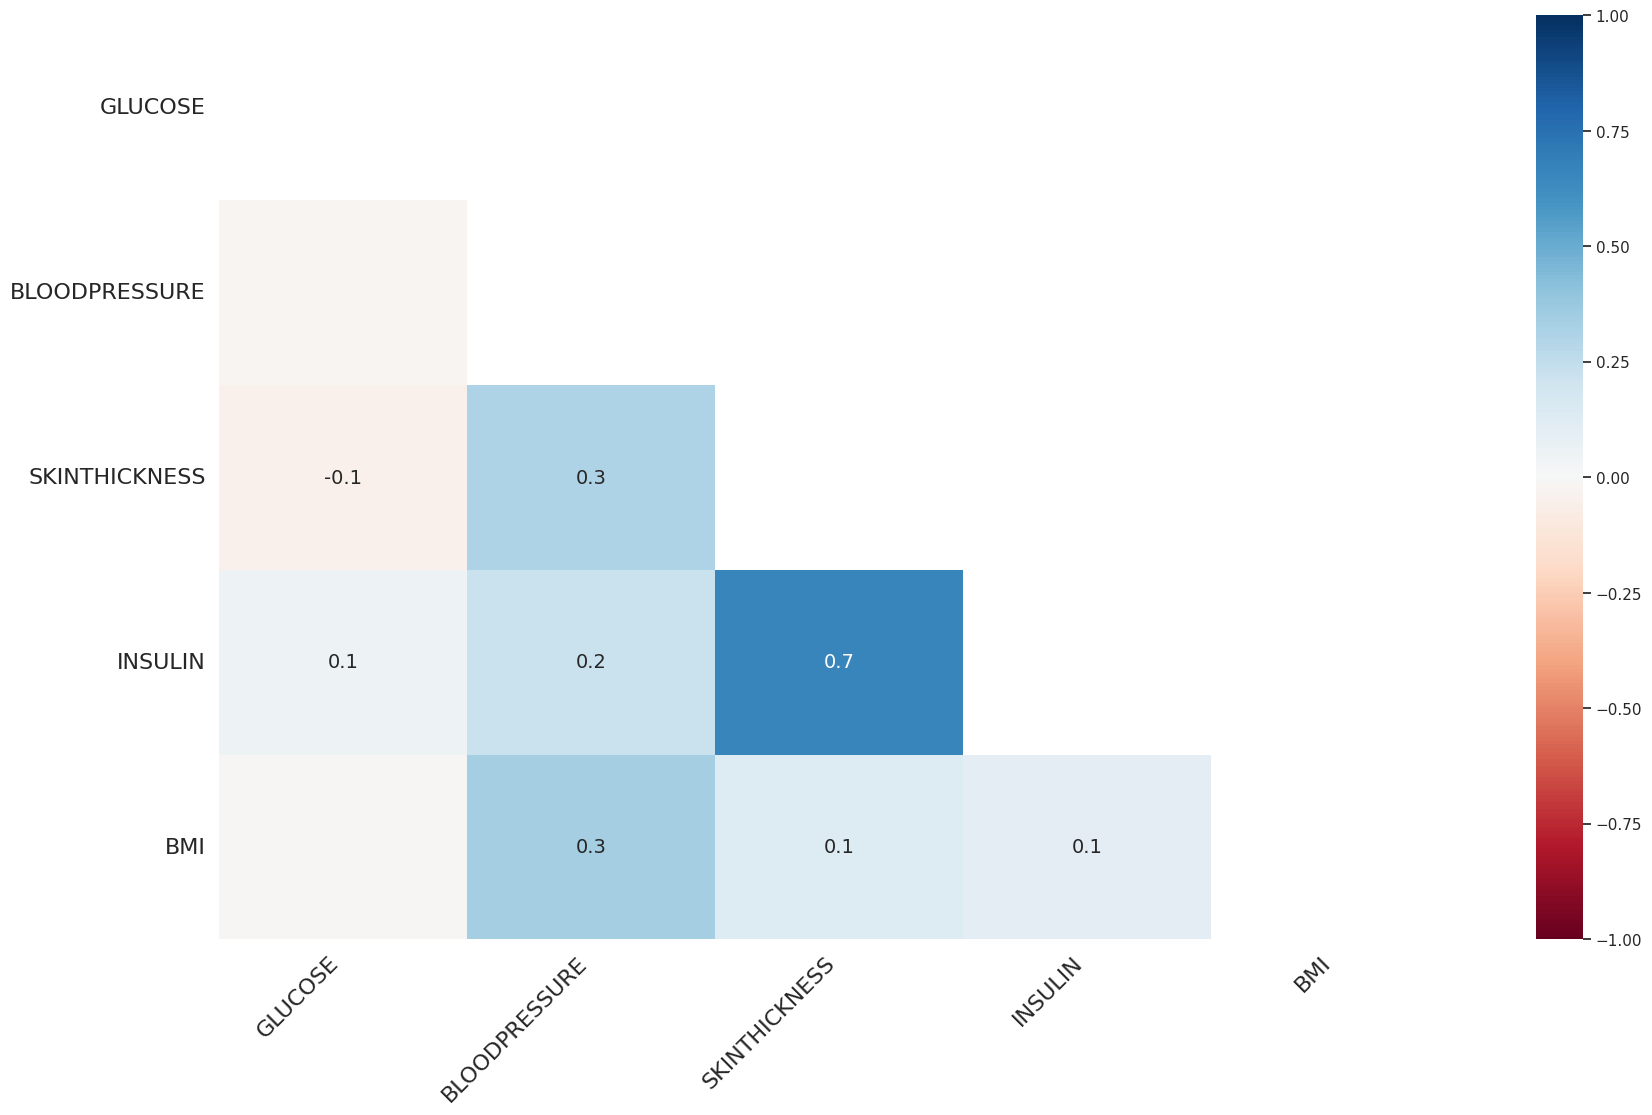

In [23]:
#displaying heatmap to visualize correlations between columns with missing values
msno.heatmap(df)
plt.show()

In [24]:
#creating the missing values table and na_columns

def missing_values_table(dataframe, na_name=False):
   na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]


   n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
   ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
   missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
   print(missing_df, end="\n")


   if na_name:
       return na_columns


missing_values_table(df)
na_cols = missing_values_table(df, True)

               n_miss  ratio
INSULIN           374 48.630
SKINTHICKNESS     228 29.650
BLOODPRESSURE      35  4.550
BMI                11  1.430
GLUCOSE             5  0.650
               n_miss  ratio
INSULIN           374 48.630
SKINTHICKNESS     228 29.650
BLOODPRESSURE      35  4.550
BMI                11  1.430
GLUCOSE             5  0.650


In [25]:
#investigating the relationship between missing values in specific columns (na_columns) 
#and the target variable (target)

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "OUTCOME", na_cols)

                 TARGET_MEAN  Count
GLUCOSE_NA_FLAG                    
0                      0.349    764
1                      0.400      5


                       TARGET_MEAN  Count
BLOODPRESSURE_NA_FLAG                    
0                            0.345    734
1                            0.457     35


                       TARGET_MEAN  Count
SKINTHICKNESS_NA_FLAG                    
0                            0.333    541
1                            0.390    228


                 TARGET_MEAN  Count
INSULIN_NA_FLAG                    
0                      0.332    395
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.352    758
1                  0.182     11




In [26]:
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

In [27]:
dff.head()

,OUTCOME,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,1,6,148.000,72.000,35.000,NaN,33.600,0.627,50.000
1,0,1,85.000,66.000,29.000,NaN,26.600,0.351,31.000
2,1,8,183.000,64.000,NaN,NaN,23.300,0.672,32.000
3,0,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000
4,1,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000


In [28]:
#standardization of variables
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
dff.head()

,OUTCOME,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,1.000,0.353,0.671,0.490,0.304,NaN,0.315,0.234,0.483
1,0.000,0.059,0.265,0.429,0.239,NaN,0.172,0.117,0.167
2,1.000,0.471,0.897,0.408,NaN,NaN,0.104,0.254,0.183
3,0.000,0.059,0.290,0.429,0.174,0.127,0.202,0.038,0.000
4,1.000,0.000,0.600,0.163,0.304,0.228,0.509,0.944,0.200


In [29]:
#filling the missing values with the average of their 5 neighbours' values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff.head()

,OUTCOME,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,1.000,0.353,0.671,0.490,0.304,0.456,0.315,0.234,0.483
1,0.000,0.059,0.265,0.429,0.239,0.075,0.172,0.117,0.167
2,1.000,0.471,0.897,0.408,0.274,0.324,0.104,0.254,0.183
3,0.000,0.059,0.290,0.429,0.174,0.127,0.202,0.038,0.000
4,1.000,0.000,0.600,0.163,0.304,0.228,0.509,0.944,0.200


In [30]:
#inversing the dataframe 
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
dff.head()

,OUTCOME,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,1.000,6.000,148.000,72.000,35.000,334.200,33.600,0.627,50.000
1,0.000,1.000,85.000,66.000,29.000,56.200,26.600,0.351,31.000
2,1.000,8.000,183.000,64.000,32.200,238.000,23.300,0.672,32.000
3,0.000,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000
4,1.000,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000


In [31]:
mis_columns = ["GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI"]

df[mis_columns] = dff[mis_columns]

In [32]:
df.isnull().sum()

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [33]:
#creating new features
# Dividing the age variable into categories and creating new age variables
df.loc[(df["AGE"] >= 21) & (df["AGE"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 50), "NEW_AGE_CAT"] = "senior"
df.head()

# converting BMI variable to a categorical variables
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])
df.head()

# converting glucose variable to a categorical variables
df["NEW_GLUCOSE"] = pd.cut(x=df["GLUCOSE"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])
df.head()

# Creating a categorical variable by considering age and body mass index together
df.loc[(df["BMI"] < 18.5) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

# Creating a categorical variable based on age and glucose values together
df.loc[(df["GLUCOSE"] < 70) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["GLUCOSE"] < 70) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["GLUCOSE"] >= 70) & (df["GLUCOSE"] < 100)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["GLUCOSE"] >= 70) & (df["GLUCOSE"] < 100)) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["GLUCOSE"] >= 100) & (df["GLUCOSE"] <= 125)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["GLUCOSE"] >= 100) & (df["GLUCOSE"] <= 125)) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["GLUCOSE"] > 125) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["GLUCOSE"] > 125) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"
df.head()

# Deriving a Categorical Variable with Insulin Value
def set_insulin(dataframe, col_name="INSULIN"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df["NEW_GLUCOSE*INSULIN"] = df["GLUCOSE"] * df["INSULIN"]

# Attention to zero values!!!!
#df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]
df["NEW_GLUCOSE*PREGNANCIES"] = df["GLUCOSE"] * (1+ df["PREGNANCIES"])




#AGE
# df["AGE"].describe()

# df.loc[(df['AGE'] < 29), 'NEW_AGE_CAT'] = 'very_young'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41), 'NEW_AGE_CAT'] = 'young'
# df.loc[(df['AGE'] >= 41), 'NEW_AGE_CAT'] = 'middle_aged'

# df["NEW_AGE_CAT"].value_counts()
# df["NEW_AGE_CAT"].value_counts(normalize=True)

# quick_sum = pd.DataFrame({"COUNT": df["NEW_AGE_CAT"].value_counts(),
#                             "RATIO": df["NEW_AGE_CAT"].value_counts() / len(df),
#                             "TARGET_MEAN": df.groupby("NEW_AGE_CAT")["OUTCOME"].mean()})
# df.head()


#BMI
# df["BMI"].describe()

# df.loc[(df['BMI'] < 19), 'BMI_CATEGORY'] = 'underweight'
# df.loc[(df['BMI'] >= 19) & (df['BMI'] < 25), 'BMI_CATEGORY'] = 'normal_weight'
# df.loc[(df['BMI'] >= 25) & (df['BMI'] < 30), 'BMI_CATEGORY'] = 'overweight'
# df.loc[(df['BMI'] >= 30), 'BMI_CATEGORY'] = 'obesity'

# BMI_Summary = df.groupby('BMI_CATEGORY')['OUTCOME'].mean()
# df.head()

# #Glucose
# df["GLUCOSE"].describe()
# df.loc[(df['GLUCOSE'] <= 140), 'NEW_GLUCOSE'] = 'normal'
# df.loc[(df['GLUCOSE'] > 140), 'NEW_GLUCOSE'] = 'high_risk'

# #insulin
# df['INSULIN_RESISTANCE'] = df['INSULIN'].apply(lambda x: 1 if x > 100 else 0)
# Insulin_summary = df.groupby('INSULIN_RESISTANCE')['OUTCOME'].mean()
# df.head()

# #BMI & Age
# df.loc[(df['AGE'] < 29) & (df['BMI'] < 19), 'NEW_AGE_BMI_CAT'] = 'very_young_underweight'
# df.loc[(df['AGE'] < 29) & (df['BMI'] >= 19) & (df['BMI'] < 25), 'NEW_AGE_BMI_CAT'] = 'very_young_normal_weight'
# df.loc[(df['AGE'] < 29) & (df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_AGE_BMI_CAT'] = 'very_young_overweight'
# df.loc[(df['AGE'] < 29) & (df['BMI'] >= 30), 'NEW_AGE_BMI_CAT'] = 'very_young_obesity'

# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] < 19), 'NEW_AGE_BMI_CAT'] = 'young_underweight'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] >= 19) & (df['BMI'] < 25), 'NEW_AGE_BMI_CAT'] = 'young_normal_weight'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_AGE_BMI_CAT'] = 'young_overweight'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] >= 30), 'NEW_AGE_BMI_CAT'] = 'young_obesity'

# df.loc[(df['AGE'] >= 41) & (df['BMI'] < 19), 'NEW_AGE_BMI_CAT'] = 'middle_aged_underweight'
# df.loc[(df['AGE'] >= 41) & (df['BMI'] >= 19) & (df['BMI'] < 25), 'NEW_AGE_BMI_CAT'] = 'middle_aged_normal_weight'
# df.loc[(df['AGE'] >= 41) & (df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_AGE_BMI_CAT'] = 'middle_aged_overweight'
# df.loc[(df['AGE'] >= 41) & (df['BMI'] >= 30), 'NEW_AGE_BMI_CAT'] = 'middle_aged_obesity'

# # #glucose & Age
# df.loc[(df['AGE'] < 29) & (df['GLUCOSE'] <= 140), 'NEW_AGE_GLUCOSE_CAT'] = 'very_young_normal'
# df.loc[(df['AGE'] < 29) & (df['GLUCOSE'] > 140), 'NEW_AGE_GLUCOSE_CAT'] = 'very_young_high_risk'

# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['GLUCOSE'] <= 140), 'NEW_AGE_GLUCOSE_CAT'] = 'young_normal'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['GLUCOSE'] > 140), 'NEW_AGE_GLUCOSE_CAT'] = 'young_high_risk'

# df.loc[(df['AGE'] >= 41) & (df['GLUCOSE'] <= 140), 'NEW_AGE_GLUCOSE_CAT'] = 'middle_aged_normal'
# df.loc[(df['AGE'] >= 41) & (df['GLUCOSE'] > 140), 'NEW_AGE_GLUCOSE_CAT'] = 'middle_aged_high_risk'

# #Glucose & Insulin
# df.loc[(df['INSULIN_RESISTANCE'] == 1) & (df['GLUCOSE'] <= 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'insulin_resistant_normal_glucose'
# df.loc[(df['INSULIN_RESISTANCE'] == 1) & (df['GLUCOSE'] > 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'insulin_resistant_high_risk_glucose'

# df.loc[(df['INSULIN_RESISTANCE'] == 0) & (df['GLUCOSE'] <= 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'no_insulin_resistance_normal_glucose'
# df.loc[(df['INSULIN_RESISTANCE'] == 0) & (df['GLUCOSE'] > 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'no_insulin_resistance_high_risk_glucose'

# #insulin glucose interaction
# df['INSULIN_GLUCOSE_INTERACTION'] = df['INSULIN'] * df['GLUCOSE']

# CORRELATION_INS_GLU = df[['INSULIN', 'GLUCOSE', 'INSULIN_GLUCOSE_INTERACTION']].corr()
# print(CORRELATION_INS_GLU)

# #GLUCOSE Pregnancy interaction
# df['GLUCOSE_PREGNANCIES_INTERACTION'] = df['GLUCOSE'] * df['PREGNANCIES']

# CORRELATION_GLU_PRE = df[['INSULIN', 'PREGNANCIES', 'GLUCOSE_PREGNANCIES_INTERACTION']].corr()
# print(CORRELATION_GLU_PRE)

# #skinthickness glucose
# df['SKINTHICKNESS_GLUCOSE_INTERACTION'] = df['SKINTHICKNESS'] * df['GLUCOSE']
# CORRELATION_ST_GLU = df[['SKINTHICKNESS', 'GLUCOSE', 'SKINTHICKNESS_GLUCOSE_INTERACTION']].corr()
# print(CORRELATION_GLU_PRE)


# # #Pregnancies
# # df["PREGNANCIES"].describe()
# # correlation = df[['PREGNANCIES', 'OUTCOME']].corr()

# # #BLOODPRESSURE * DIABETESPEDIGREEFUNCTION
# # df["BP_DPF_INTERACTION"] =  df["BLOODPRESSURE"] * df["DIABETESPEDIGREEFUNCTION"]
# # CORRELATION_BP_DPF = df[['BLOODPRESSURE', 'DIABETESPEDIGREEFUNCTION', 'BP_DPF_INTERACTION']].corr()
# # print(CORRELATION_BP_DPF)

# # #BMI * Glucose
# # df["B_G_INTERACTION"] = df["BMI"] * df["GLUCOSE"]
# # CORRELATION_BG = df[['BMI', 'GLUCOSE', 'B_G_INTERACTION']].corr()
# # print(CORRELATION_BG)

# #BMI * Insulin * Glucose Interaction
# df["B_I_G_INTERACTION"] = df["BMI"] * df["INSULIN"] * df["GLUCOSE"]
# CORRELATION_BIG = df[['BMI', 'INSULIN', 'GLUCOSE', 'B_I_G_INTERACTION']].corr()
# print(CORRELATION_BIG)

# #BMI * Insulin * Glucose Interaction *Skinthickness
# df["B_I_G_ST_INTERACTION"] = df["BMI"] * df["INSULIN"] * df["GLUCOSE"] * df["SKINTHICKNESS"]
# CORRELATION_BIGST = df[['BMI', 'INSULIN', 'GLUCOSE', 'SKINTHICKNESS', 'B_I_G_ST_INTERACTION']].corr()
# print(CORRELATION_BIGST)

# #BMI * Insulin * Glucose Interaction *Skinthickness * Bloodpressure
# df["B_I_G_ST_BP_INTERACTION"] = df["BMI"] * df["INSULIN"] * df["GLUCOSE"] * df["SKINTHICKNESS"] * df["BLOODPRESSURE"]
# CORRELATION_BIGSTBP = df[['BMI', 'INSULIN', 'GLUCOSE', 'SKINTHICKNESS', 'BLOODPRESSURE', 'B_I_G_ST_BP_INTERACTION']].corr()
# print(CORRELATION_BIGSTBP)


In [34]:
#calling the grab_col_names function again to reindentify and recategorize the variables 
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 769
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [35]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,334.200,33.600,0.627,50.000,1,senior,Obese,Prediabetes,obesesenior,highsenior,Abnormal,49461.600,1036.000
1,1,85.000,66.000,29.000,56.200,26.600,0.351,31.000,0,mature,Overweight,Normal,obesemature,normalmature,Normal,4777.000,170.000
2,8,183.000,64.000,32.200,238.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,obesemature,highmature,Abnormal,43554.000,1647.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,178.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,137.000


In [36]:
#encode binary categorical columns (columns that contain only 2 unique values) 
#into numeric values (0 and 1) using LabelEncoder

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    #dataframe.loc[:, binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]


for col in binary_cols:
    df = label_encoder(df, col)
print(binary_cols)

['NEW_AGE_CAT', 'NEW_GLUCOSE', 'NEW_INSULIN_SCORE']


In [37]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,334.200,33.600,0.627,50.000,1,1,Obese,1,obesesenior,highsenior,0,49461.600,1036.000
1,1,85.000,66.000,29.000,56.200,26.600,0.351,31.000,0,0,Overweight,0,obesemature,normalmature,1,4777.000,170.000
2,8,183.000,64.000,32.200,238.000,23.300,0.672,32.000,1,0,Healthy,1,obesemature,highmature,0,43554.000,1647.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,Overweight,0,obesemature,normalmature,1,8366.000,178.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,Obese,0,obesemature,highmature,0,23016.000,137.000


In [38]:
#calling the grab_col_names function again to reindentify and recategorize the variables 
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 769
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 5


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   PREGNANCIES               769 non-null    int64   
 1   GLUCOSE                   769 non-null    float64 
 2   BLOODPRESSURE             769 non-null    float64 
 3   SKINTHICKNESS             769 non-null    float64 
 4   INSULIN                   769 non-null    float64 
 5   BMI                       769 non-null    float64 
 6   DIABETESPEDIGREEFUNCTION  769 non-null    float64 
 7   AGE                       769 non-null    float64 
 8   OUTCOME                   769 non-null    int64   
 9   NEW_AGE_CAT               769 non-null    int64   
 10  NEW_BMI                   769 non-null    category
 11  NEW_GLUCOSE               769 non-null    int64   
 12  NEW_AGE_BMI_NOM           769 non-null    object  
 13  NEW_AGE_GLUCOSE_NOM       769 non-null    object  

In [40]:
#processing of rearranging rare categorical values in the data set accordingly.
#since there is no value below 0.01, this won't change anything on this project

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "OUTCOME", cat_cols)

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df = rare_encoder(df, 0.01)


#variable that has 2 classes and one of them is less than 0.01? If yes, we can drop them 
# useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
#                 (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

# df.drop(useless_cols, axis=1, inplace=True)


NEW_AGE_BMI_NOM : 3
                   COUNT  RATIO  TARGET_MEAN
NEW_AGE_BMI_NOM                             
obesemature          675  0.878        0.333
obesesenior           90  0.117        0.489
underweightmature      4  0.005        0.000


NEW_AGE_GLUCOSE_NOM : 8
                     COUNT  RATIO  TARGET_MEAN
NEW_AGE_GLUCOSE_NOM                           
hiddenmature           251  0.326        0.271
hiddensenior            24  0.031        0.375
highmature             241  0.313        0.602
highsenior              58  0.075        0.569
lowmature               10  0.013        0.000
lowsenior                1  0.001        0.000
normalmature           177  0.230        0.068
normalsenior             7  0.009        0.286


OUTCOME : 2
         COUNT  RATIO  TARGET_MEAN
OUTCOME                           
0          500  0.650        0.000
1          269  0.350        1.000


NEW_AGE_CAT : 2
             COUNT  RATIO  TARGET_MEAN
NEW_AGE_CAT                           
0        

In [41]:
#performing one-hot encoding on categorical columns with more than 2 and up to 10 unique values.
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

#selecting columns with unique values between 3 and 10.
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)
print(ohe_cols)

['NEW_BMI', 'NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM']


In [42]:
df.shape

(769, 25)

In [43]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_AGE_BMI_NOM_obesemature,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_GLUCOSE_NOM_hiddenmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_normalmature
0,6,148.000,72.000,35.000,334.200,33.600,0.627,50.000,1,1,1,0,49461.600,1036.000,False,False,True,False,True,False,False,False,True,False,False
1,1,85.000,66.000,29.000,56.200,26.600,0.351,31.000,0,0,0,1,4777.000,170.000,False,True,False,True,False,False,False,False,False,False,True
2,8,183.000,64.000,32.200,238.000,23.300,0.672,32.000,1,0,1,0,43554.000,1647.000,True,False,False,True,False,False,False,True,False,False,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,0,1,8366.000,178.000,False,True,False,True,False,False,False,False,False,False,True
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,0,0,23016.000,137.000,False,False,True,True,False,False,False,True,False,False,False


In [44]:
#converting the bool columns to integer
bool_cols = df.select_dtypes(include='bool').columns

df[bool_cols] = df[bool_cols].astype('int')

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_AGE_BMI_NOM_obesemature,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_GLUCOSE_NOM_hiddenmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_normalmature
0,6,148.000,72.000,35.000,334.200,33.600,0.627,50.000,1,1,1,0,49461.600,1036.000,0,0,1,0,1,0,0,0,1,0,0
1,1,85.000,66.000,29.000,56.200,26.600,0.351,31.000,0,0,0,1,4777.000,170.000,0,1,0,1,0,0,0,0,0,0,1
2,8,183.000,64.000,32.200,238.000,23.300,0.672,32.000,1,0,1,0,43554.000,1647.000,1,0,0,1,0,0,0,1,0,0,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,0,1,8366.000,178.000,0,1,0,1,0,0,0,0,0,0,1
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,0,0,23016.000,137.000,0,0,1,1,0,0,0,1,0,0,0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PREGNANCIES                       769 non-null    int64  
 1   GLUCOSE                           769 non-null    float64
 2   BLOODPRESSURE                     769 non-null    float64
 3   SKINTHICKNESS                     769 non-null    float64
 4   INSULIN                           769 non-null    float64
 5   BMI                               769 non-null    float64
 6   DIABETESPEDIGREEFUNCTION          769 non-null    float64
 7   AGE                               769 non-null    float64
 8   OUTCOME                           769 non-null    int64  
 9   NEW_AGE_CAT                       769 non-null    int64  
 10  NEW_GLUCOSE                       769 non-null    int64  
 11  NEW_INSULIN_SCORE                 769 non-null    int64  
 12  NEW_GLUC

In [46]:
#calling the grab_col_names function again to reindentify and recategorize the variables 
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 769
Variables: 25
cat_cols: 15
num_cols: 10
cat_but_car: 0
num_but_cat: 15


In [47]:
#performing standardization for numerical variables.
num_cols

# scaler = StandardScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

# df.shape
# df.head()


scaler = RobustScaler()
df[num_cols] =  scaler.fit_transform(df[num_cols])
df[num_cols].head()


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,0.600,0.738,0.000,0.500,2.084,0.152,0.670,1.235,2.033,0.937
1,-0.400,-0.762,-0.375,0.000,-0.753,-0.609,-0.052,0.118,-0.634,-0.453
2,1.000,1.571,-0.500,0.267,1.102,-0.967,0.788,0.176,1.681,1.918
3,-0.400,-0.667,-0.375,-0.500,-0.367,-0.446,-0.534,-0.471,-0.420,-0.440
4,-0.600,0.476,-2.000,0.500,0.388,1.185,5.018,0.235,0.455,-0.506


In [48]:
#establishing the model
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.707
Precision: 0.53
F1: 0.6
Auc: 0.75


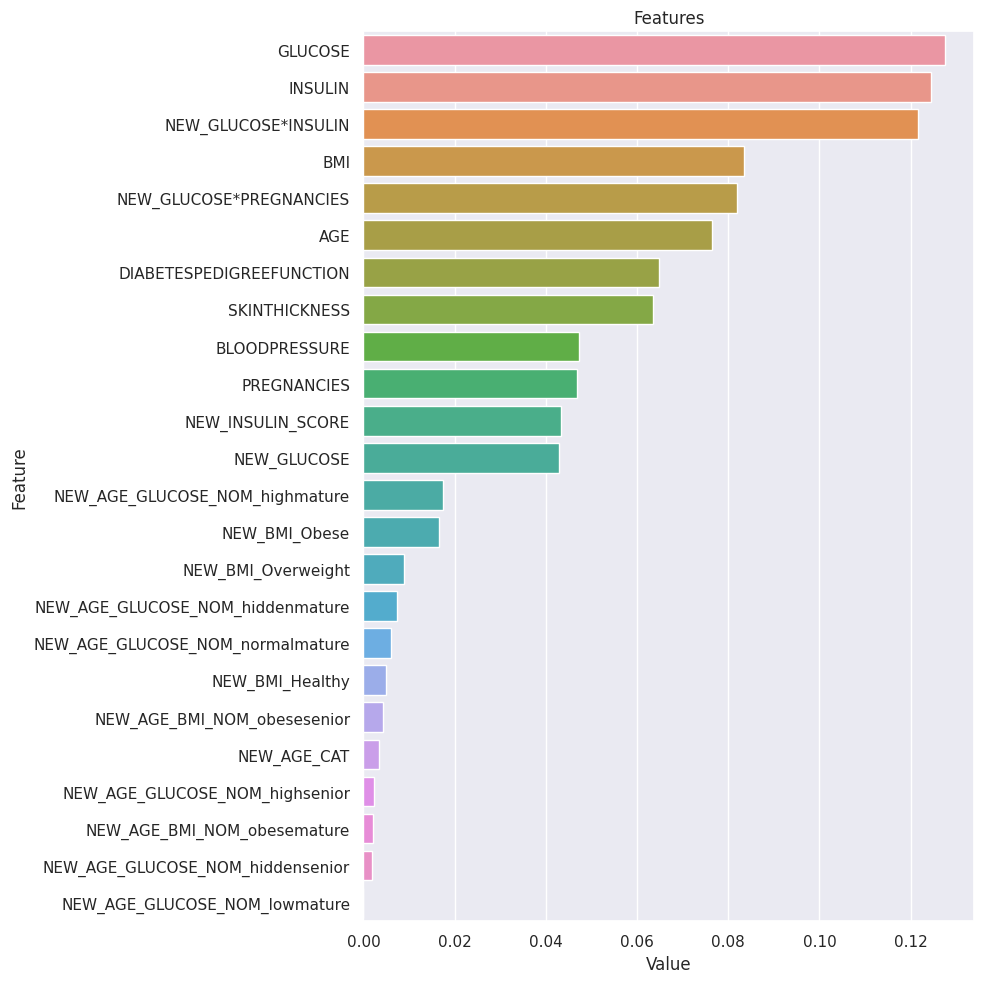

In [49]:
#plotting variables' importance in the model
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)